# 多模式订正融合算法（Multiple Model Blending Method）

#### —— 以温度为例展示多模式订正融合算法

国家气象中心天气预报技术研发室  代刊  
山东省气象台  马继望  
June, 2021  


#### Objectives
* 了解"National Blend of Models"的技术流程。
* 掌握“Decaying Average”的算法；
* 掌握多模式权重融合算法；

---

In [1]:
# set up things
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# load necessary libraries
# you should install cartopy with 'conda install -c conda-forge cartopy'
import sys
import pickle
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt

from nmc_met_graphics.plot.china_map import add_china_map_2cartopy

## National Blend of Models
---

NBM是美国新一代国家级数字化网格预报指导产品。从2016年发布V1.0，至今已经升级到V4.0版本。NBM融合了30多个不同的模式，以提供统一的、一致的最优预报起点。

<img src="./images/nbm.jpg" alt="image" style="height: 450px;">

NBM的技术路线如下。主要分为两步，第一步是偏差订正，第二步是基于权重的集成：

<img src="./images/BRR-040_页面_07.jpg" alt="image" style="height: 450px;">

## 基于Decaying Averaging的偏差订正  
---

<img src="./images/BRR-040_页面_08.jpg" alt="image" style="height: 450px;">

In [3]:
#
# 读入数据

# 2020年4月1-30日的预报误差滑动平均（alpha=0.2）
decay_err = xr.open_dataset("./samples/model_blending/v2/last_err.nc")
lon = decay_err['lon'].values
lat = decay_err['lat'].values
lons, lats = np.meshgrid(lon, lat)
decay_err = decay_err['data'].values

# 2020年4月1-30日的预报绝对误差滑动平均（alpha=0.2）
decay_mae = xr.open_dataset("./samples/model_blending/v2/last_mae.nc")
decay_mae = decay_mae['data'].values

# 维度（3:EC/NCEP/Grapes模式, 40:预报时效/6小时间隔, 101:纬度, 101:经度）
print(decay_err.shape)

(3, 40, 101, 101)


In [4]:
# 2020年5月1-30日t-1时刻的2m温度预报误差和观测值
fcst_last = xr.open_dataset("./samples/model_blending/v2/forecast_history.nc")
fcst_last = fcst_last['data'].values
print('fcst_last: ', fcst_last.shape)

obsr_last = xr.open_dataset("./samples/model_blending/v2/observation_history.nc")
obsr_last = obsr_last['data'].values
print('obsr_last: ', obsr_last.shape)

fcst_last:  (30, 3, 40, 101, 101)
obsr_last:  (30, 40, 101, 101)


In [5]:
# 2020年5月1-30日t时刻的m温度预报误差和观测值
fcst = xr.open_dataset("./samples/model_blending/v2/forecast.nc")
fcst = fcst['data'].values
print('fcst: ', fcst.shape)

obsr = xr.open_dataset("./samples/model_blending/v2/ground_truth.nc")
obsr = obsr['data'].values
print('obsr: ', obsr.shape)

fcst:  (30, 3, 40, 101, 101)
obsr:  (30, 40, 101, 101)


<div class="alert alert-success">
    <b>EXERCISE</b>:
    滑动衰减平均偏差方法:
     <ul>
      <li>基于上述数据，计算5月10日20时起报72h时效的模式订正场.</li>
      <li>对比模式原始预报场与订正场之间的差别.</li>
    </ul>
</div>

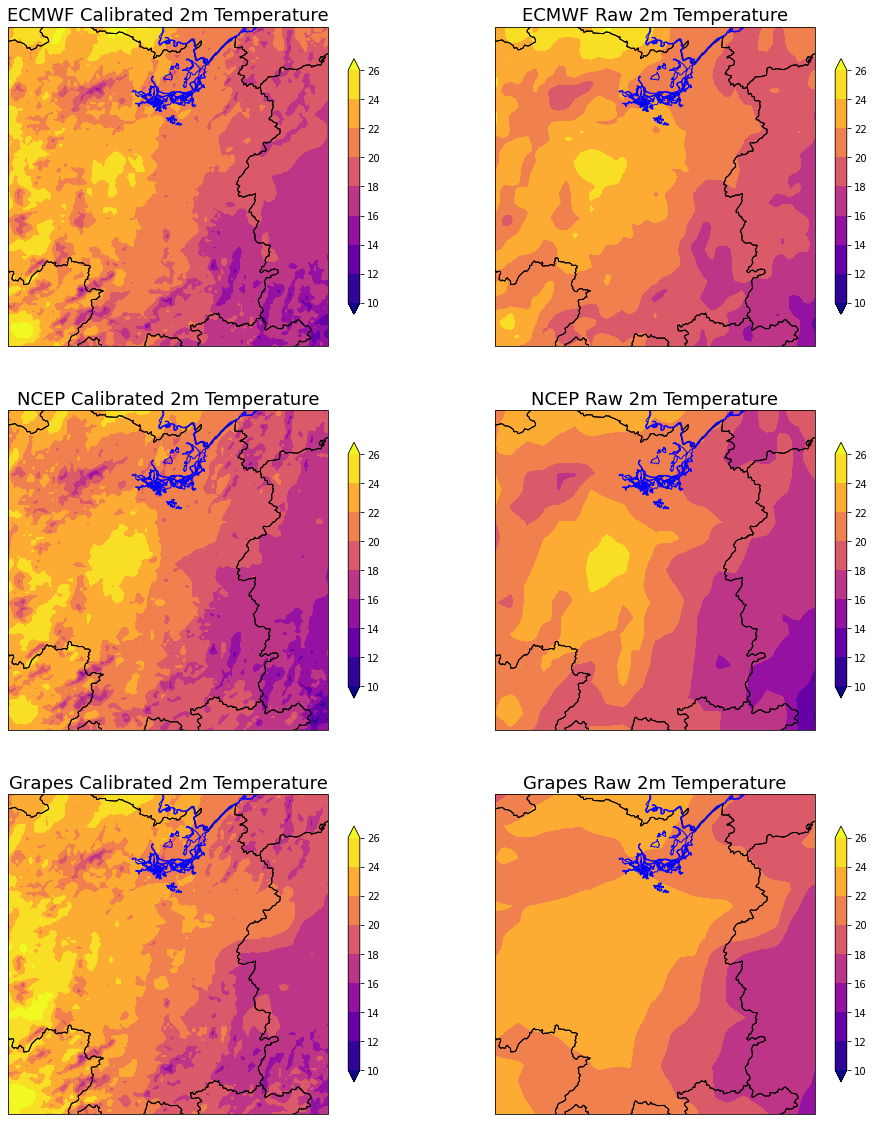

In [6]:
# decaying average alpha
alpha = 0.2

# calculate the bias-corrected forecast
for i in range(10):
    err_update = fcst_last[i,] - obsr_last[i,]
    decay_err = (1 - alpha) * decay_err + alpha * err_update
    fcst_raw = fcst[i,]
    obsr_raw = obsr[i,]
    fcst_cal = fcst_raw - decay_err
    
#
# draw raw and bias-corrected forecast

# set figure and subplot size
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(16, 20))

# set contour levels
clevs = np.arange(10., 28, 2)

# draw forecast
ax = plt.subplot(321, projection=datacrs)
plot = ax.contourf(lons, lats, np.squeeze(fcst_cal[0,12,:,:]), clevs,
                   cmap="plasma", transform=datacrs, extend="both")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.coastlines('50m', edgecolor='grey', linewidth=0.75)
fig.colorbar(plot, shrink=0.8, ax=ax, location="right")
title = "ECMWF Calibrated 2m Temperature"
plt.title(title, fontsize=18)

ax = plt.subplot(322, projection=datacrs)
plot = ax.contourf(lons, lats, np.squeeze(fcst_raw[0,12,:,:]), clevs,
                   cmap="plasma", transform=datacrs, extend="both")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.coastlines('50m', edgecolor='grey', linewidth=0.75)
fig.colorbar(plot, shrink=0.8, ax=ax, location="right")
title = "ECMWF Raw 2m Temperature"
plt.title(title, fontsize=18)

ax = plt.subplot(323, projection=datacrs)
plot = ax.contourf(lons, lats, np.squeeze(fcst_cal[1,12,:,:]), clevs,
                   cmap="plasma", transform=datacrs, extend="both")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.coastlines('50m', edgecolor='grey', linewidth=0.75)
fig.colorbar(plot, shrink=0.8, ax=ax, location="right")
title = "NCEP Calibrated 2m Temperature"
plt.title(title, fontsize=18)

ax = plt.subplot(324, projection=datacrs)
plot = ax.contourf(lons, lats, np.squeeze(fcst_raw[1,12,:,:]), clevs,
                   cmap="plasma", transform=datacrs, extend="both")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.coastlines('50m', edgecolor='grey', linewidth=0.75)
fig.colorbar(plot, shrink=0.8, ax=ax, location="right")
title = "NCEP Raw 2m Temperature"
plt.title(title, fontsize=18)

ax = plt.subplot(325, projection=datacrs)
plot = ax.contourf(lons, lats, np.squeeze(fcst_cal[2,12,:,:]), clevs,
                   cmap="plasma", transform=datacrs, extend="both")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.coastlines('50m', edgecolor='grey', linewidth=0.75)
fig.colorbar(plot, shrink=0.8, ax=ax, location="right")
title = "Grapes Calibrated 2m Temperature"
plt.title(title, fontsize=18)

ax = plt.subplot(326, projection=datacrs)
plot = ax.contourf(lons, lats, np.squeeze(fcst_raw[2,12,:,:]), clevs,
                   cmap="plasma", transform=datacrs, extend="both")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.coastlines('50m', edgecolor='grey', linewidth=0.75)
fig.colorbar(plot, shrink=0.8, ax=ax, location="right")
title = "Grapes Raw 2m Temperature"
plt.title(title, fontsize=18)

plt.show()

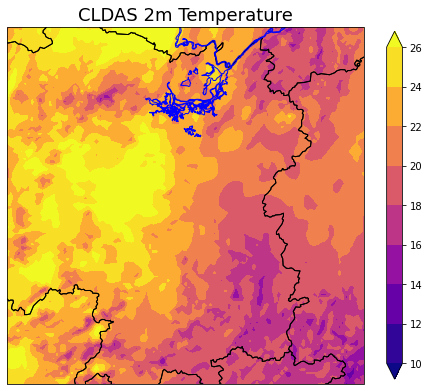

In [7]:
#
# draw raw and bias-corrected forecast

# set figure and subplot size
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(8, 8))

# set contour levels
clevs = np.arange(10., 28, 2)

# draw forecast
ax = plt.subplot(111, projection=datacrs)
plot = ax.contourf(lons, lats, np.squeeze(obsr_raw[12,:,:]), clevs,
                   cmap="plasma", transform=datacrs, extend="both")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.coastlines('50m', edgecolor='grey', linewidth=0.75)
fig.colorbar(plot, shrink=0.8, ax=ax, location="right")
title = "CLDAS 2m Temperature"
plt.title(title, fontsize=18)
plt.show()

<div class="alert alert-success">
    <b>EXERCISE</b>:
    对比2020年5月份各模式订正前后的预报误差MAE:
     <ul>
      <li>采用Decaying average方法订正5月份的2m温度预报.</li>
      <li>对比不同时效、不同模式的5月份区域平均MAE的原始预报和订正后的预报.</li>
    </ul>
</div>

In [8]:
# decaying average alpha
alpha = 0.2

# calculate the bias-corrected forecast
fcst_raw_mae = np.zeros((30,3,40))
fcst_cal_mae = np.zeros((30,3,40))
for i in range(30):
    # bias correction
    err_update = fcst_last[i,] - obsr_last[i,]
    decay_err = (1 - alpha) * decay_err + alpha * err_update
    fcst_cal = fcst[i,] - decay_err
    
    # compute the mean absolute error
    fcst_raw_mae[i,] = np.mean(np.abs(fcst[i,] - obsr[i,]), axis=(2,3))
    fcst_cal_mae[i,] = np.mean(np.abs(fcst_cal - obsr[i,]), axis=(2,3))
    
# compute monthly average
fcst_raw_mae = np.mean(fcst_raw_mae,axis=0)
fcst_cal_mae = np.mean(fcst_cal_mae,axis=0)

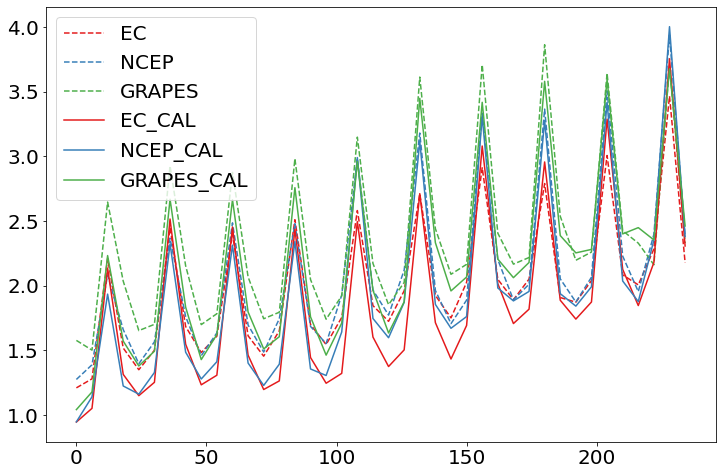

In [9]:
# compare the raw and bias-corrected forecast
plt.figure(figsize=(12,8))
plt.rcParams.update({"font.size":20})
plt.rc('axes', prop_cycle=cycler(color=["#e41a1c","#377eb8", "#4daf4a"]))
plt.plot(np.arange(40)*6, fcst_raw_mae.T, label=['EC','NCEP','GRAPES'], linestyle="--")
plt.plot(np.arange(40)*6, fcst_cal_mae.T, label=['EC_CAL','NCEP_CAL','GRAPES_CAL'])
plt.legend()
plt.show()

<div class="alert alert-success">
    <b>EXERCISE</b>:
    alpha系数对订正效果的影响:
     <ul>
      <li>对上述试验, 设置不同的alpha系数，分析对订正结果的影响.</li>
    </ul>
</div>

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

<img src="./images/Decaying averaged weight.png" alt="image" style="height: 700px;">

## 基于误差的权重集成  
---

<img src="./images/BRR-040_页面_09.jpg" alt="image" style="height: 450px;">

<img src="./images/BRR-040_页面_10.jpg" alt="image" style="height: 450px;">

<img src="./images/BRR-040_页面_14.jpg" alt="image" style="height: 450px;">

<img src="./images/BRR-040_页面_15.jpg" alt="image" style="height: 450px;">

<div class="alert alert-success">
    <b>EXERCISE</b>:
    多模式权重集成方法:
     <ul>
      <li>基于上述数据，计算5月10日20时起报72h时效的模式订正场及多模式集成预报场.</li>
      <li>对比模式原始预报场、模式订正预报与多模式之间的差别.</li>
      <li>对比EC, NCEP和GRAPES的权重场分布特征.</li>
    </ul>
</div>

In [10]:
# decaying average alpha
alpha = 0.2

# calculate the bias-corrected forecast
for i in range(10):
    err_update = fcst_last[i,] - obsr_last[i,]
    decay_err = (1 - alpha) * decay_err + alpha * err_update
    decay_mae = (1 - alpha) * decay_mae + alpha * np.abs(err_update)
    fcst_raw = fcst[i,]
    obsr_raw = obsr[i,]
    fcst_cal = fcst_raw - decay_err
    
    # 计算3个模式的权重系数
    weights = []
    for j in range(3):
        weights.append((1.0/decay_mae[j,])/(np.sum(1.0/decay_mae, axis=0)))
    weights = np.array(weights)
        
    # 计算融合预报场
    fcst_blend = np.sum(fcst_cal * weights, axis=0)

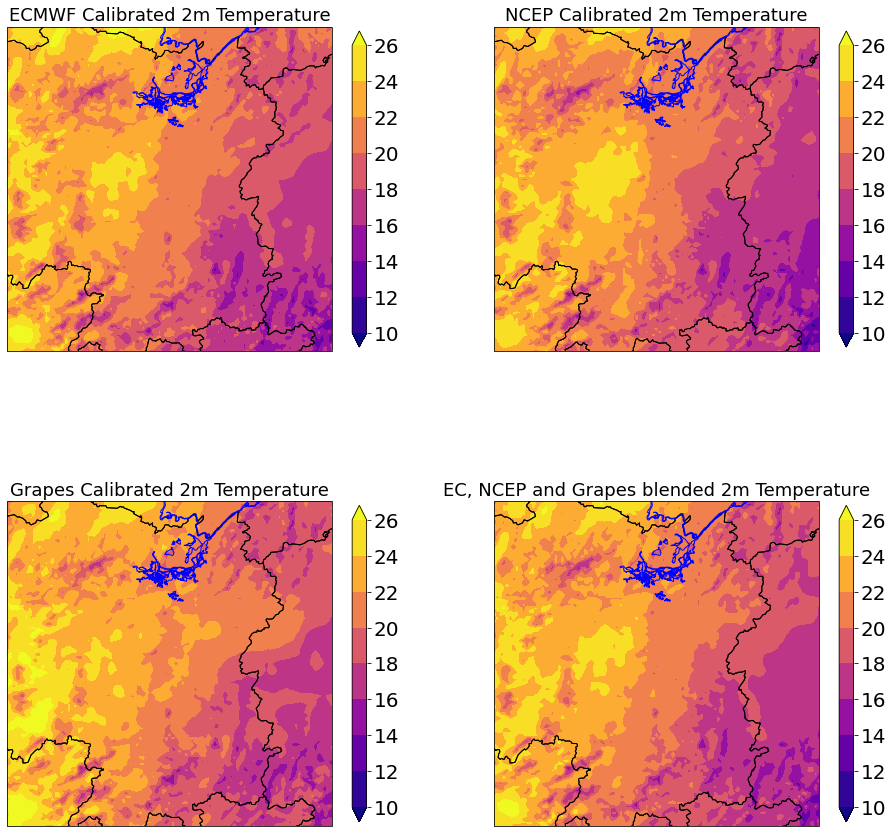

In [11]:
#
# draw raw and bias-corrected forecast

# set figure and subplot size
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(16, 16))

# set contour levels
clevs = np.arange(10., 28, 2)

# draw forecast
ax = plt.subplot(221, projection=datacrs)
plot = ax.contourf(lons, lats, np.squeeze(fcst_cal[0,12,:,:]), clevs,
                   cmap="plasma", transform=datacrs, extend="both")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.coastlines('50m', edgecolor='grey', linewidth=0.75)
fig.colorbar(plot, shrink=0.8, ax=ax, location="right")
title = "ECMWF Calibrated 2m Temperature"
plt.title(title, fontsize=18)

ax = plt.subplot(222, projection=datacrs)
plot = ax.contourf(lons, lats, np.squeeze(fcst_cal[1,12,:,:]), clevs,
                   cmap="plasma", transform=datacrs, extend="both")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.coastlines('50m', edgecolor='grey', linewidth=0.75)
fig.colorbar(plot, shrink=0.8, ax=ax, location="right")
title = "NCEP Calibrated 2m Temperature"
plt.title(title, fontsize=18)

ax = plt.subplot(223, projection=datacrs)
plot = ax.contourf(lons, lats, np.squeeze(fcst_cal[2,12,:,:]), clevs,
                   cmap="plasma", transform=datacrs, extend="both")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.coastlines('50m', edgecolor='grey', linewidth=0.75)
fig.colorbar(plot, shrink=0.8, ax=ax, location="right")
title = "Grapes Calibrated 2m Temperature"
plt.title(title, fontsize=18)

ax = plt.subplot(224, projection=datacrs)
plot = ax.contourf(lons, lats, np.squeeze(fcst_blend[12,:,:]), clevs,
                   cmap="plasma", transform=datacrs, extend="both")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.coastlines('50m', edgecolor='grey', linewidth=0.75)
fig.colorbar(plot, shrink=0.8, ax=ax, location="right")
title = "EC, NCEP and Grapes blended 2m Temperature"
plt.title(title, fontsize=18)

plt.show()

<div class="alert alert-success">
    <b>EXERCISE</b>:
    对比2020年5月份各模式集成前后的预报误差MAE:
     <ul>
      <li>采用Decaying average方法订正5月份的2m温度预报.</li>
      <li>对比不同时效、不同模式的5月份区域平均MAE的订正后预报，并与集成MAE进行对比.</li>
    </ul>
</div>

In [12]:
# decaying average alpha
alpha = 0.2

# calculate the bias-corrected forecast
fcst_cal_mae = np.zeros((30,3,40))
fcst_blend_mae = np.zeros((30,40))
for i in range(30):
    # bias correction
    err_update = fcst_last[i,] - obsr_last[i,]
    decay_err = (1 - alpha) * decay_err + alpha * err_update
    decay_mae = (1 - alpha) * decay_mae + alpha * np.abs(err_update)
    fcst_raw = fcst[i,]
    obsr_raw = obsr[i,]
    fcst_cal = fcst_raw - decay_err
    
    # 计算3个模式的权重系数
    weights = []
    for j in range(3):
        weights.append((1.0/decay_mae[j,])/(np.sum(1.0/decay_mae, axis=0)))
    weights = np.array(weights)
        
    # 计算融合预报场
    fcst_blend = np.sum(fcst_cal * weights, axis=0)
    
    # compute the mean absolute error
    fcst_cal_mae[i,] = np.mean(np.abs(fcst_cal - obsr[i,]), axis=(2,3))
    fcst_blend_mae[i,] = np.mean(np.abs(fcst_blend - obsr[i,]), axis=(1,2))
    
# compute monthly average
fcst_cal_mae = np.mean(fcst_cal_mae,axis=0)
fcst_blend_mae = np.mean(fcst_blend_mae,axis=0)

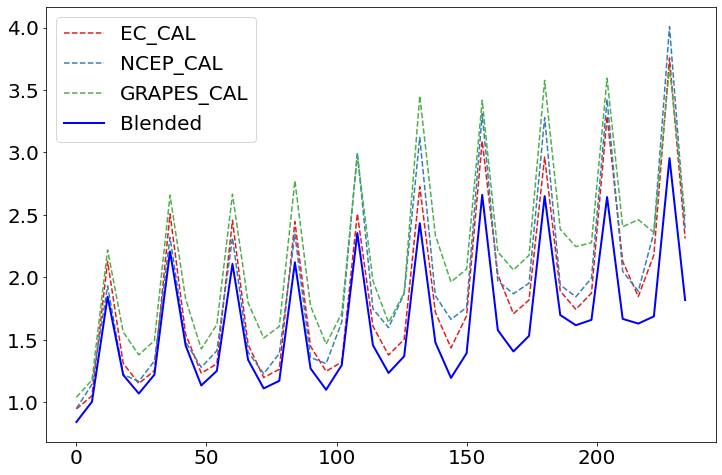

In [13]:
# compare the raw and bias-corrected forecast
plt.figure(figsize=(12,8))
plt.rcParams.update({"font.size":20})
plt.rc('axes', prop_cycle=cycler(color=["#e41a1c","#377eb8", "#4daf4a"]))
plt.plot(np.arange(40)*6, fcst_cal_mae.T, label=['EC_CAL','NCEP_CAL','GRAPES_CAL'], linestyle="--")
plt.plot(np.arange(40)*6, fcst_blend_mae, label='Blended', color="Blue", linewidth=2)
plt.legend()
plt.show()